# Comparison of CMEMS at LOCO location with CMEMS averaged over DCA

In [1]:
import scipy.io as sio
import numpy as np
import pandas as pd
import gsw
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
import datetime
from datetime import timedelta
from scipy import interpolate
import seaborn as sns
sns.set_style('dark')
from info import datadir, figdir

In [2]:
data = sio.loadmat(datadir+'LOCO_CMEMS_val.mat')

time = data['time'][0]
t0 = datetime.datetime(1950,1,1,0,0) # origin of time = 1 January 1950, 00:00:00 UTC
dates = np.array([t0 + datetime.timedelta(hours=i) for i in time])
depth_cmems = data['depth_cmems'][0]
depth_loco = data['depth_loco'][0]
Time_cmems = data['Time_cmems']
Time_loco = data['Time_loco']
Depth_cmems = data['Depth_cmems']
Depth_loco = data['Depth_loco']

SA_cmems = data['SA_cmems']
SA_loco = data['SA_loco']
CT_cmems = data['CT_cmems']
CT_loco = data['CT_loco']
sigma0_cmems = data['sigma0_cmems']
sigma0_loco = data['sigma0_loco']
mld_cmems = data['mld_cmems'][0]
mld_loco = data['mld_loco'][0]

In [3]:
data = sio.loadmat(datadir+'timedepth_DCA.mat')

time_new = data['time'][0]
t0 = datetime.datetime(1950,1,1,0,0) # origin of time = 1 January 1950, 00:00:00 UTC
dates_new = np.array([t0 + datetime.timedelta(hours=i) for i in time_new])
time_new = time_new[12*10:12*25]
dates_new = dates_new[12*10:12*25]
depth_new = data['depth'][0]
depth_2000_ind = np.where(depth_new>2000)[0][0]
depth_cmems = depth_new[0:depth_2000_ind+1]
p = data['p'][0]

SA = data['SA'][12*10:12*25,0:depth_2000_ind+1]
CT = data['CT'][12*10:12*25,0:depth_2000_ind+1]
sigma0 = data['sigma0'][12*10:12*25,0:depth_2000_ind+1]
mld_mean = data['mld_mean'][0][12*10:12*25]
mld_max = data['mld_max'][0][12*10:12*25]

In [4]:
def regrid_vertical(data, time, vert):
    """
    vert: either depth or pressure
    """
    f = interpolate.interp2d(time,vert,np.transpose(data), kind='linear')
    xi = time
    yi = np.linspace(vert[0],vert[-1],len(vert))
    Time,Vert = np.meshgrid(xi,yi)
    data_interp = f(xi,yi)
    return Time,Vert,data_interp

# Regrid SA, CT, sigma0 averaged over DCA to regular depth grid (same as at LOCO mooring)
_,_,SA_regrid = regrid_vertical(SA, time_new, depth_cmems)
_,_,CT_regrid = regrid_vertical(CT, time_new, depth_cmems)
Time,Depth,sigma0_regrid = regrid_vertical(sigma0, time_new, depth_cmems)

In [5]:
def plotTimeDepth(ax,Time,Vert,data,levels,cmap,verttype,minv,maxv,label,title,inv_cbar=False):
    plot = ax.contourf(Time,Vert,data,levels=levels,extend='both',cmap=cmap)
    cbar = plt.colorbar(plot, ax=ax)
    if verttype=='depth':
        ax.set_ylabel('Depth (m)', fontsize=15)
    else:
        ax.set_ylabel('Pressure (dbar)', fontsize=15)
    ax.set_ylim(minv,maxv)
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.tick_params(axis='both', labelsize=13)
    ax.set_xticks(time[0::12])
    ax.set_xticklabels([dates[i].year for i in np.arange(0,len(time[0::12])*12,12)])
    ax.set_title(title,fontsize=17)
    cbar.ax.set_ylabel(label,fontsize=14)
    cbar.ax.tick_params(axis='y', which='both', labelsize=14)
    cbar.ax.get_yaxis().labelpad = 25
    if inv_cbar:
        cbar.ax.invert_yaxis()

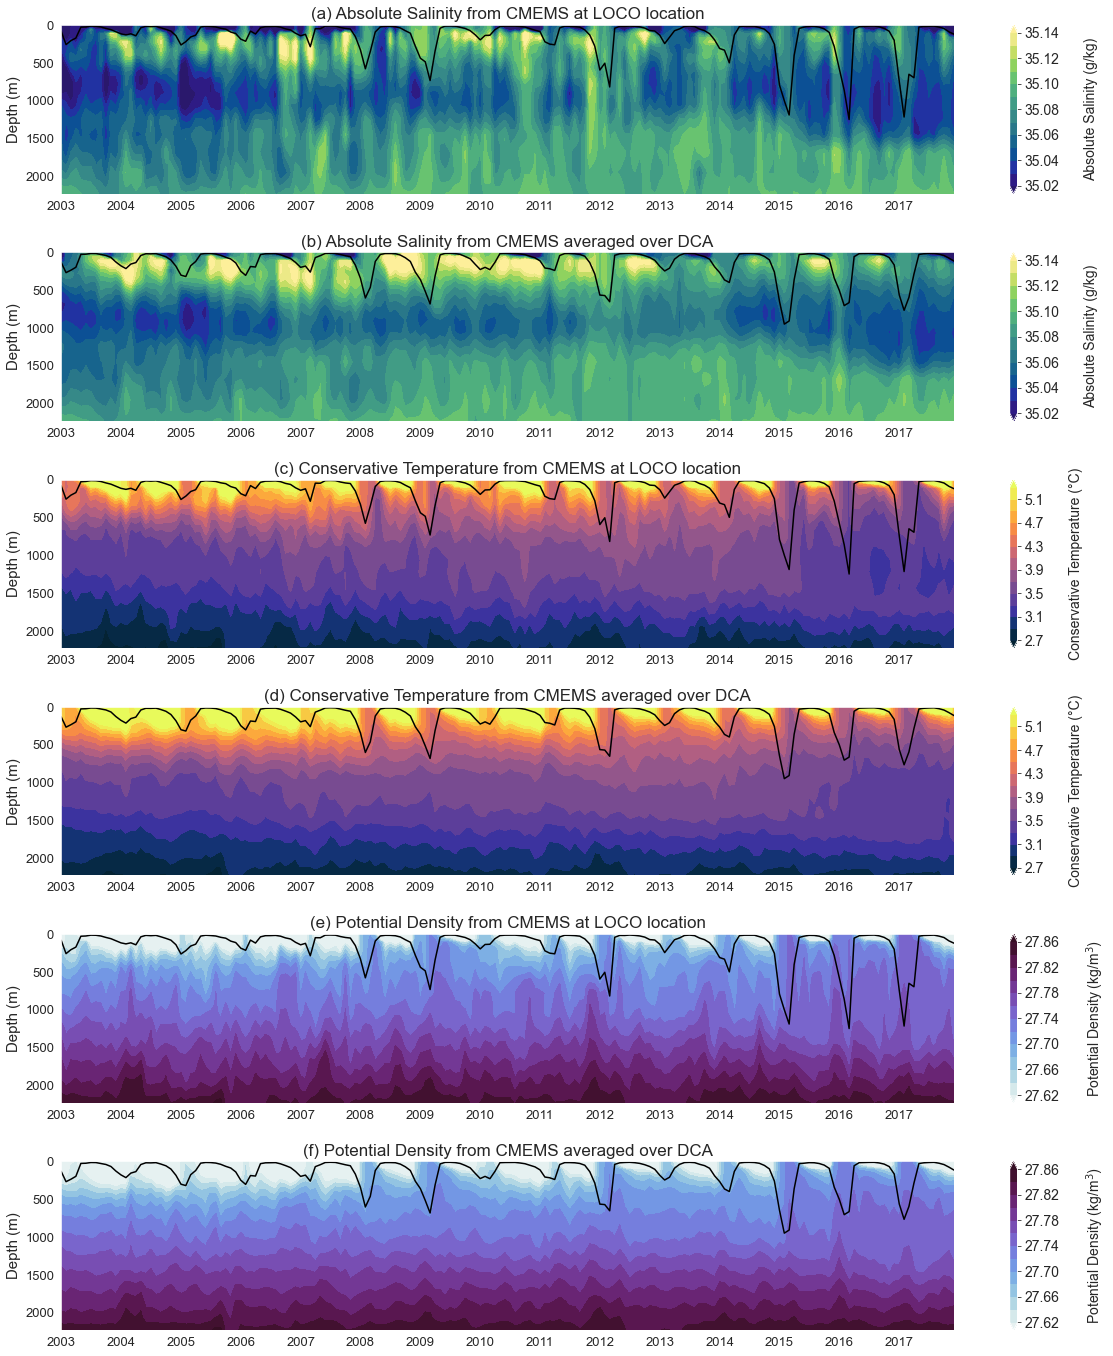

In [6]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(20,24))

S_levels = np.arange(35.02,35.141,0.01)
T_levels = np.arange(2.7,5.41,0.2)
sigma0_levels = np.arange(27.62,27.87,0.02)

plotTimeDepth(ax1,Time_cmems,Depth_cmems,SA_cmems,S_levels,'cmo.haline','depth',0,np.max(depth_loco),
              'Absolute Salinity (g/kg)','(a) Absolute Salinity from CMEMS at LOCO location')
ax1.plot(time,mld_cmems,color='black')
plotTimeDepth(ax2,Time,Depth,SA_regrid,S_levels,'cmo.haline','depth',0,np.max(depth_loco),
              'Absolute Salinity (g/kg)','(b) Absolute Salinity from CMEMS averaged over DCA')
ax2.plot(time_new,mld_mean,color='black')

plotTimeDepth(ax3,Time_cmems,Depth_cmems,CT_cmems,T_levels,'cmo.thermal','depth',0,np.max(depth_loco),
              'Conservative Temperature ('+'\u00B0'+'C)','(c) Conservative Temperature from CMEMS at LOCO location')
ax3.plot(time,mld_cmems,color='black')
plotTimeDepth(ax4,Time,Depth,CT_regrid,T_levels,'cmo.thermal','depth',0,np.max(depth_loco),
              'Conservative Temperature ('+'\u00B0'+'C)','(d) Conservative Temperature from CMEMS averaged over DCA')
ax4.plot(time_new,mld_mean,color='black')

plotTimeDepth(ax5,Time_cmems,Depth_cmems,sigma0_cmems,sigma0_levels,'cmo.dense','depth',0,np.max(depth_loco),
              'Potential Density (kg/m$^3$)','(e) Potential Density from CMEMS at LOCO location')
ax5.plot(time,mld_cmems,color='black')
plotTimeDepth(ax6,Time,Depth,sigma0_regrid,sigma0_levels,'cmo.dense','depth',0,np.max(depth_loco),
              'Potential Density (kg/m$^3$)','(f) Potential Density from CMEMS averaged over DCA')
ax6.plot(time_new,mld_mean,color='black')

plt.subplots_adjust(hspace=0.35)
plt.savefig(figdir+'CMEMS_av_nonav.png',bbox_inches='tight')
plt.show()